# Generators explained
## Target audience
Beginners who are familiar with the basics of python. Exposure to basic concepts like iteration using for loops and while loops are required. Knowledge of classes will help.

## Objective
To gain a conceptual understanding of how python generators work, and how to use them to make your code more efficient and sleek.

## Outline
* What are generators? (~5 min)
    * Introduction to standard iteration
    * Iteration using generator functions
        * Infinite series
    * Generator expressions
* How do they work? (~7 min)
    * Sending data back into generators
        * Example - Running metric evaluation
    * Stacking generators and the `yield from` statement
        * Example - binary tree traversal   

* A brief foray into async and co-routines (~5 min)
    * Understanding `yield`
* Generators in practice - data loading in machine learning (~3 min)

# Iteration
Iteration is a type of control flow in which a set of statements are repeated. Suppose we want the first `n` square numbers. We can iterate over the first `n` numbers and square each one as follows:

In [1]:
def squares(n):
    i = 1
    out = []
    while i<n:
        out.append(i**2)
        i+=1
    return out

In [2]:
squares(10)

[1, 4, 9, 16, 25, 36, 49, 64, 81]

But this restricts us to a finite `n`. If we desire a stream of squares indefinitely, this method has two issues:

* If we know an upper limit on the number of squares, we can just make all the squares until then and store them. However, this requires a huge amount of memory and is highly inefficient.

* If we do not know any upper limit, this method is no good.

We can solve these issues using a __generator__ function.

# Generators
Any function with a `yield` statement in it becomes a special type of function called a generator function. An example will help us understand what this means.

In [3]:
def squares():
    i = 1
    while True:
        yield i**2 # where the magic happens
        i+=1

Let's see what happens when we call this function:

In [4]:
squares()

<generator object squares at 0x0000019BC6AF83B8>

To get the stuff which generators yield, we need to use the `next` built-in function:

In [5]:
g = squares() # lets store the generator in a variable
next(g)

1

In [6]:
next(g)

4

In [7]:
next(g)

9

Let's walk through what just happened. The first time `next(g)` was called, control started executing from the beginning of the function. It continues to execute normally until it hits a `yield`. So, it executed the following statements:

    i=1
    while True:
        yield i**2
        

Once it hits a `yield`, control stops executing the generator function body. It returns control to where ever `next` was called, and it also returns the value which was yielded. In this case, the value yielded is 1\*\*2 = 1.

Now, the second time `next` is called, control continues where it left off last time. It also __retains local variables__. This means that `i` is still equal to `1`. In order, the statements it executes are:

* `i+=1` `i` is now 2. Now, control is at the end of the while loop body, so it loops back to the beginning.

* `yield i**2` Encounters a `yield`, so it stops executing. Value yielded is 2\*\*2 = 4.

We see that the generator is somewhat 'stateful' in that it remembers it's local namespace. The next time you call `next`, `i` would be equal to 2, which would resulting in yielding a 9. This is exactly what we saw earlier.

Note that this generator will always encounter a yield statement as it is embedded in an infinite loop. What happens if we write a generator which doesn't have infinite yields?

In [8]:
def countdown(n):
    while n>0:
        yield n
        n-=1

This generator basically counts down from some `n` until it hits 0.

In [9]:
countdown_3 = countdown(3)

In [10]:
next(countdown_3)

3

In [11]:
next(countdown_3)

2

In [12]:
next(countdown_3)

1

In [13]:
next(countdown_3)

StopIteration: 

Now we see that if there are no yield statements when next is called, a `StopIteration` exception is raised. This means the generator is out of things to generate.

This business of calling next everytime is a bit of a hassle. But, python's for loops can actually loop over a generator and automatically call the next for you:

In [14]:
for i in countdown(10):
    print(i)

10
9
8
7
6
5
4
3
2
1


Notice that no errors are thrown, and we didnt need to explicitly call next.

What we have done is to reformulate iteration using generators. When the above loop was executed, all 10 numbers were not stored. Only the single `n` was stored in the generator, which will save a lot of memory at scale.

You can also quickly whip up generators using one line __generator expressions__:

In [15]:
g = (i**2 for i in range(10))
g

<generator object <genexpr> at 0x0000019BC6BD93B8>

In [16]:
for i in g:
    print(i)

0
1
4
9
16
25
36
49
64
81


Note that this is different from a list comprehension(notice the lack of square brackets []) in that a list comprehension creates a whole list and stores it in memory.

In [17]:
g_list = [i**2 for i in range(10)]
g_list

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

## Sending to generators
The yield statement can do more than just return a value when a next is called. It can also be used in expressions as the right hand side of an assignment:

In [18]:
def recv():
    a = yield
    print(f"I got: {a}")
    

In [19]:
receiver = recv()

The first `next` moves control over to the yield statement.

In [20]:
next(receiver)

Then, we can send in a value into the yield statement using the `generator.send` function:

In [21]:
receiver.send(24)

I got: 24


StopIteration: 

Since there were no more yield statements, a stop iteration was also raised. 

Note that the first ever call to a generator must be a next call, as there is no yield statement in the beginning to send a value to:

In [22]:
receiver = recv()
receiver.send(5)

TypeError: can't send non-None value to a just-started generator

Also, this reveals that calling the `next` function is equivalent to `generator.send(None)`

The `yield` statement can be used both to recieve and return values. Lets look at this example which returns whatever was sent to it:

In [23]:
def echo():
    a = yield # first next call moves to this yield statement
    while True:
        a = yield a 
        # when control stops at this yield, return a
        # when control begins from this yield, get the sent value and put it into a

In [24]:
e = echo()
next(e)

In [25]:
e.send('hi')

'hi'

In [26]:
e.send(42)

42

We can better understand the `a = yield a` statement as follows:

    variable = yield expr
translates to

    yield expr
    variable = what was sent
    

So, what you yield doesnt affect what is assigned to the left hand side

In [27]:
from pytorch_utils.nb_figure import *

In [28]:
from pylab import *
rcParams['axes.grid']=True

In [29]:
def test_updater(updater, num=200, u=0, sig=20):
    """Test a running updater on a noisy sinusoid. Assumes that
    the updater has one function called send, which takes in x_n
    and returns y_n."""
    
    nf = NBFigure(image_path='testing_plot.png')
    nf.display()
    
    ax = nf.getAxis()
    inp, = ax.plot([])
    l, = ax.plot([],'--')
    
    ax.legend(['Input', 'Output'])
    
    x = []
    y = []
    inputs = []
    for i in range(200):
        x.append(i)
        
        r = randn()*sig + u + 100*sin(0.1*i)
        inputs.append(r)
        y.append(updater.send(r))
        
        l.set_data(x,y)
        inp.set_data(x,inputs)
        
        nf.update()

Let's use this feature to build a running averager. First, let's build one without using generators:

In [30]:
class RunningAvg():
    def __init__(self):
        self.n=0
        self.s=0
        
    def reset(self):
        self.n=0
        self.s=0
        
    def send(self, x):
        self.s+=x
        self.n+=1
        
        return self.s/self.n

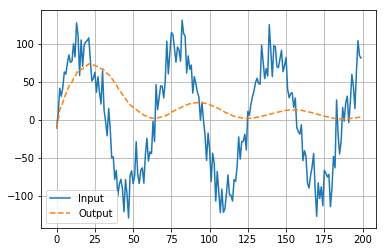

In [31]:
test_updater(RunningAvg())

It works fine, but the code is quite verbose, and we had to write a whole class just to build quite a simple thing. Let's write a version using the `yield` statement:

In [32]:
def averager():
    s = yield
    n = 1
    while True:
        s += yield s/n
        n += 1

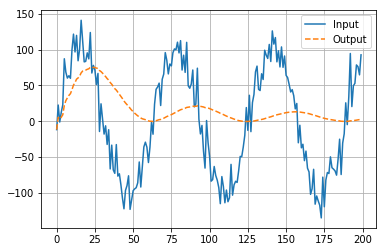

In [33]:
avg = averager()
next(avg)
test_updater(avg)

Not only does that code look much cleaner and it is just one function, but it is also slightly faster as it avoids the overheads of a whole class:

In [34]:
def test(updater, size=1_000_000):
    """Test performance of the updater by running 
    it on a large sequence of inputs"""
    t = arange(size)
    test_input = 100*sin(0.1*t)+randn(size)*20
    output = [updater.send(i) for i in test_input]
    return output

In [35]:
%%timeit
u = averager()
next(u)
test(u)

706 ms ± 43.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
%%timeit
u = RunningAvg()
test(u)

904 ms ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Stacking generators
Suppose we had a generator which yields values another generator. An example of this is shown below

In [37]:
def gen1():
    yield 'a'
    yield 'b'
    yield 'c'

In [38]:
def gen2():
    for i in gen1():
        yield i
    yield 'd'
    yield 'e'

In [39]:
for i in gen2():
    print(i)

a
b
c
d
e


A shorthand for the for loop over `gen1` is `yield from`.

In [40]:
def gen3():
    yield from gen1()
    yield 'd'
    yield 'e'

In [41]:
for i in gen3():
    print(i)

a
b
c
d
e


The `yield from gen` expression can be roughly translated to:
    
    for i in gen
        yield i
        
However, it has some more subtleties which will not be discussed here.

## Example of stacking generators
One neat example of stacked generators is binary tree traversal. Recall that you can traverse a binary tree in three ways: 

* In-order
* Pre-order
* Post-order

Before we get into generators, let's write some simple code to setup a binary tree, and then write an inorder traversal function without using generators.

In [42]:
class BTree():
    def __init__(self, dat, left=None, right=None):
        self.dat = dat
        self.left = left
        self.right = right

Let's make a simple binary tree with 6 elements:

In [43]:
one, three, six = BTree(1),BTree(3),BTree(6)
two = BTree(2,one,three)
five = BTree(5,left=None,right=six)
four = BTree(4,two,five)
root = four

In [44]:
def inorder_loop(btree):
    if btree==None:
        return []
    left = inorder_loop(btree.left)
    right = inorder_loop(btree.right)
    return left + [btree.dat] + right

In [45]:
inorder_loop(root)

[1, 2, 3, 4, 5, 6]

In [46]:
def preorder_loop(btree):
    if btree==None:
        return []
    left = preorder_loop(btree.left)
    right = preorder_loop(btree.right)
    return [btree.dat] + left  + right

In [47]:
preorder_loop(root)

[4, 2, 1, 3, 5, 6]

It works well, and the code is quite concise and readable. However, we face the issue of memory if the tree is very large, as the traversal returns the whole list at once. Let's write a version using stacked generators:

In [48]:
def inorder_gen(btree):
    if btree != None:
        yield from inorder_gen(btree.left)
        yield btree.dat
        yield from inorder_gen(btree.right)

In [49]:
g = inorder_gen(root)
for i in g:
    print(i, end=' ')

1 2 3 4 5 6 

In [50]:
def preorder_gen(btree):
    if btree != None:
        yield btree.dat
        yield from preorder_gen(btree.left)
        yield from preorder_gen(btree.right)

In [51]:
g = preorder_gen(root)
for i in g:
    print(i, end=' ')

4 2 1 3 5 6 

This version is much more sleek, and more memory efficient. Try to see where you can use generators in your code base to improve its memory consumption!

# Digging deeper into yield

We said earlier that any function with a yield statement in it becomes a whole new type of thing - a generator function. Let's try to get a better understanding of what this means. Consider this template for a normal function:

In [52]:
def dostuff(a, b):
    print("Doing setup work...")
    a += 1
    b += 2
    # some work
    
    print("Doing some stuff on args...")
    a,b = a**b, a**(1/b)
    # some more work
    
    print("Doing lot of stuff on args...")
    # a lot of stuff we aren't interested in
    
    print("Returning some stuff...")
    return a+b

Let's run it:

In [53]:
dostuff(3,4)

Doing setup work...
Doing some stuff on args...
Doing lot of stuff on args...
Returning some stuff...


4097.259921049895

No surprise there. The whole function ran and it returned the output we wanted.

Now, suppose in the section where there is a lot of stuff we aren't interested in, someone put a yield:

In [54]:
def dostuff2(a, b):
    print("Doing setup work...")
    a += 1
    b += 2
    # some work
    
    print("Doing some stuff on args...")
    a,b = a**b, a**(1/b)
    # some more work
    
    print("Doing lot of stuff on args...")
    # a lot of stuff we aren't interested in
    yield # we didn't expect this
    
    print("Returning some stuff...")
    return a+b

Calling the function now doesn't do what we would expect if we didn't notice the yield:

In [55]:
dostuff2(3,4)

<generator object dostuff2 at 0x0000019BD7CB2CA8>

We get a generator object instead of the code running. Let's see what happens if we call next on this:

In [56]:
g = _

In [57]:
next(g)

Doing setup work...
Doing some stuff on args...
Doing lot of stuff on args...


We can see that all the code until the yield statement runs. Let's try another next:

In [58]:
next(g)

Returning some stuff...


StopIteration: 4097.259921049895

A `StopIteration` is raised, as we expected because there are no more yields. However, the value returned by function is the value of the exception... that's weird. What we have essentially done is to split up the execution of the function into different segments separated by the yield statement. Some of you may know that this is characteristic of a _coroutine_. Co-routines are functions which can pause execution and hand control over to another co-routine. They play a central role in the area of asynchronous concurrency. 

In python 3.5+, the whole async structure has been made easy using the keywords __async__ and __await__. I won't go into the details of these keywords in this talk, but you can read about them more online, to get a better understanding.

# Data loading in Machine Learning

One of the most common use cases of generators in practice is in loading data for training machine learning algorithms. When training an algorithm on a huge dataset like ImageNet, which has more than 10 million images, it's impossible to load the whole dataset into your local RAM. This is the perfect place to use a generator to load images as and when they are rqeuired for training. I'll demo a brief examples of loading the MNIST dataset, which is a dataset containing handwritten digits using the pytorch `DataLoader` class.

In [59]:
from torchvision.transforms import *
from torchvision.datasets import MNIST
import torch.utils.data as data

In [60]:
mnist_dataset = MNIST('/MNIST', transform=ToTensor()) # this downloads the dataset

In [61]:
mnist_loader = data.DataLoader(mnist_dataset) # this creates a data loader object

To get an iterator from the DataLoader object, we use the `iter` keyword. Note that iterators are slightly different from generators, but are essentially the same for most practical purposes. This means that you can still call `next` on them to yield the next value, you can embed them in for loops, etc.

In [62]:
mnist_iterator = iter(mnist_loader)
mnist_iterator

This iterators yields batches of images from the dataset. In this case, I'm using a batch size of 1. Let's get a batch and look at the first image in it.

In [63]:
images, labels = next(mnist_iterator)
images.shape

torch.Size([1, 1, 28, 28])

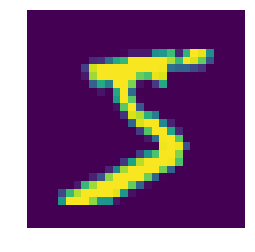

Label: 5


In [64]:
axis('off')
imshow(images[0].squeeze())
show()
print(f"Label: {labels[0]}")

Now, if we wish to loop over all the batches in our dataset, we can simply do the following:

In [65]:
batch_count = 0
for images, labels in mnist_loader:
    
    # do some training logic
    
    # counting batches to demonstrate that the iterator works
    batch_count += 1
print(f"Total of {batch_count} batches with a batch size of {images.shape[0]}")

Total of 60000 batches with a batch size of 1
